In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/emotion_from_sound_AI_project/cleaned_data/cleaned_IAD_full_features.csv')  # contains many features including arousal

import joblib
selected_features = joblib.load('/content/drive/MyDrive/emotion_from_sound_AI_project/features/top10_IAD_arousal_features.pkl')

X = df[selected_features]
y = df['arousal']


In [4]:
X.shape

(927, 10)

In [5]:
X.head(3)

,timbre_spectralflux_mean,dominance,timbre_spectralflux_std,dynamics_rms_mean,valence,dynamics_rms_std,spectral_roughness_mean,spectral_spectentropy_mean,spectral_skewness_mean,spectral_kurtosis_mean
0,48.254947,5.73,24.727503,0.095067,6.545455,0.042815,155.023072,0.858160,1.151716,3.657580
1,71.886219,3.55,35.961220,0.077893,3.227273,0.039497,760.182168,0.740798,4.648670,41.250533
2,49.664474,4.23,28.268124,0.069022,4.227273,0.038171,147.804722,0.699529,3.433726,25.080147


In [6]:
y.head()

,arousal
0,4.181818
1,6.181818
2,5.227273
3,5.500000
4,6.541667


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

def train_and_evaluate_models(df, feature_cols, target_col='arousal', test_size=0.2, random_state=42):
    """
    Train and evaluate 4 regression models on tabular audio data:
    Linear Regression, Random Forest, XGBoost, MLP Regressor.

    Parameters:
        df (pd.DataFrame): The input DataFrame
        feature_cols (list): List of selected feature column names
        target_col (str): Target variable name (default: 'arousal')
        test_size (float): Proportion of test set
        random_state (int): Random state for reproducibility

    Returns:
        results_df (pd.DataFrame): Evaluation results of each model
    """

    X = df[feature_cols]
    y = df[target_col]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Prepare scalers
    std_scaler = StandardScaler() #standardization
    minmax_scaler = MinMaxScaler() #normalization

    X_train_std = std_scaler.fit_transform(X_train)
    X_test_std = std_scaler.transform(X_test)

    X_train_minmax = minmax_scaler.fit_transform(X_train)
    X_test_minmax = minmax_scaler.transform(X_test)

    # Define models
    models = {
        "Linear Regression": (LinearRegression(), X_train_std, X_test_std),
        "Random Forest": (RandomForestRegressor(random_state=random_state), X_train, X_test),
        "XGBoost": (XGBRegressor(random_state=random_state), X_train, X_test),
        "MLP Regressor": (MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500,
                                       random_state=random_state), X_train_minmax, X_test_minmax)
    }

    results = []
    trained_models = {}

    for name, (model, X_tr, X_te) in models.items():
      # Fit once for test split eval
      model.fit(X_tr, y_train)
      y_pred = model.predict(X_te)

      r2 = r2_score(y_test, y_pred)
      mae = mean_absolute_error(y_test, y_pred)

      trained_models[name] = model

      # Cross-validation (on full training set)
      if name == "Linear Regression":
          cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='r2')
      elif name == "MLP Regressor":
          cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='r2')
      else:
          cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='r2')

      results.append({
          "Model": name,
          "R² (hold-out)": round(r2, 4),
          "MAE (hold-out)": round(mae, 4),
          "R² (CV Mean)": round(np.mean(cv_scores), 4)
      })

    results_df = pd.DataFrame(results)
    return results_df, trained_models


In [8]:
# Call the model training & evaluation function
results, trained_models = train_and_evaluate_models(df, feature_cols=selected_features, target_col='arousal')

# Print results
print(results)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


               Model  R² (hold-out)  MAE (hold-out)  R² (CV Mean)
0  Linear Regression         0.5452          0.6166        0.5003
1      Random Forest         0.7021          0.5216        0.5884
2            XGBoost         0.6824          0.5424        0.5497
3      MLP Regressor         0.6962          0.5143        0.6140


## Analysis
Among the four models, Random Forest and MLP Regressor performed best overall.
Random Forest achieved the highest R² (0.70), while MLP achieved the lowest MAE (0.51), indicating both are capable of capturing the non-linear relationships between features and arousal.

## results visualization

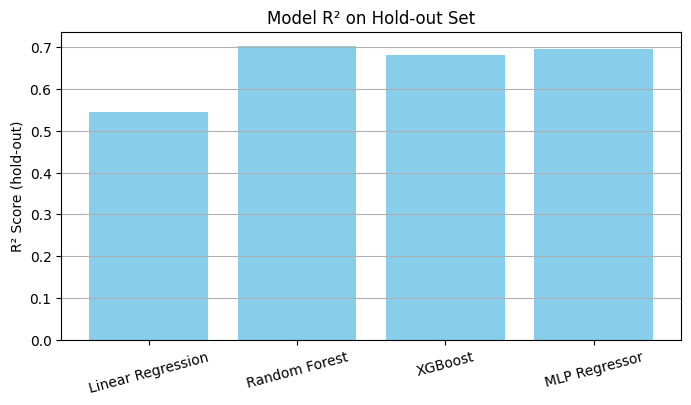

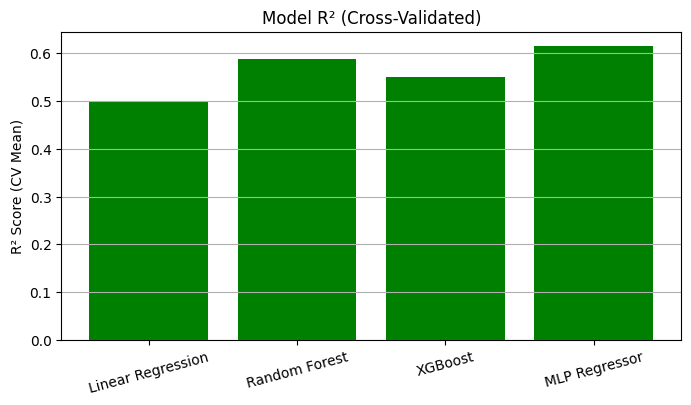

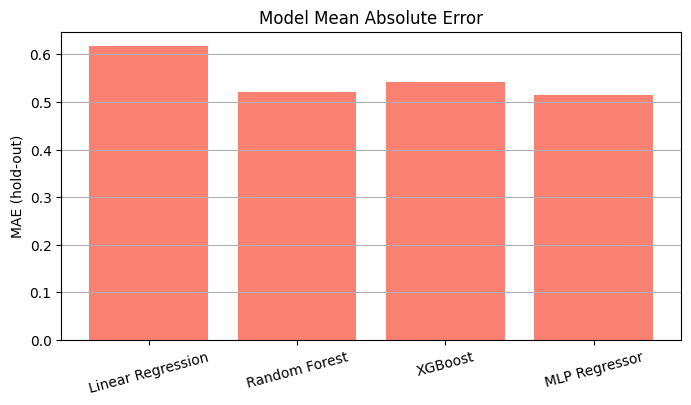

In [9]:
import matplotlib.pyplot as plt

# R² Score - Hold-out
plt.figure(figsize=(8, 4))
plt.bar(results['Model'], results['R² (hold-out)'], color='skyblue')
plt.ylabel("R² Score (hold-out)")
plt.title("Model R² on Hold-out Set")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

# R² Score - CV Mean
plt.figure(figsize=(8, 4))
plt.bar(results['Model'], results['R² (CV Mean)'], color='green')
plt.ylabel("R² Score (CV Mean)")
plt.title("Model R² (Cross-Validated)")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

# MAE - Hold-out
plt.figure(figsize=(8, 4))
plt.bar(results['Model'], results['MAE (hold-out)'], color='salmon')
plt.ylabel("MAE (hold-out)")
plt.title("Model Mean Absolute Error")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

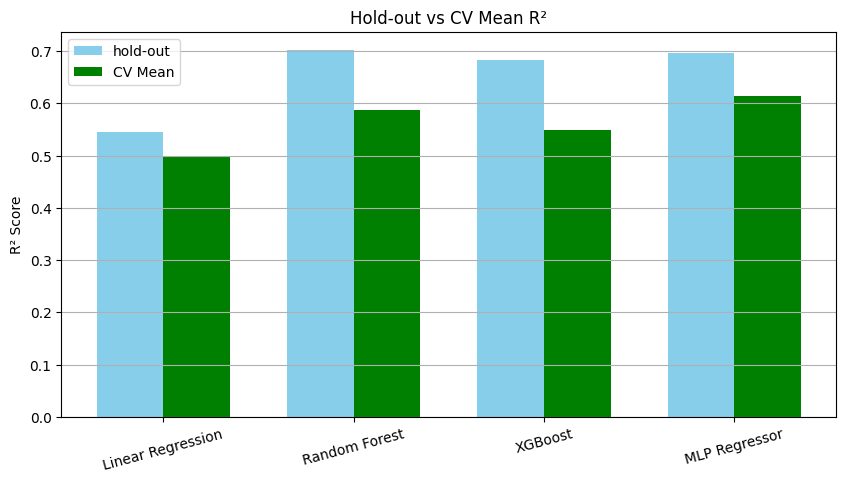

In [10]:
import numpy as np

x = np.arange(len(results['Model']))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, results['R² (hold-out)'], width, label='hold-out', color='skyblue')
plt.bar(x + width/2, results['R² (CV Mean)'], width, label='CV Mean', color='green')

plt.xticks(x, results['Model'], rotation=15)
plt.ylabel("R² Score")
plt.title("Hold-out vs CV Mean R²")
plt.legend()
plt.grid(axis='y')
plt.show()


## Analysis
On average, across multiple splits of the data, MLP generalizes better than Random Forest on your dataset.

MLP might be better at capturing non-linear relationships when dataset is small like this project.

Scaling (MinMaxScaler) likely helped MLP

## Hyperparameter Tuning

with GridSearchCV

### random forest

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best R²:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)


Best R²: 0.4695690020823016
Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


### MLP

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


mlp_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPRegressor(random_state=42, max_iter=1000))
])

param_grid = {
    'mlp__hidden_layer_sizes': [(64,), (64, 32), (128, 64)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.05]
}

grid_search_mlp = GridSearchCV(
    mlp_pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_mlp.fit(X, y)

print("Best R² (MLP):", grid_search_mlp.best_score_)
print("Best Parameters (MLP):", grid_search_mlp.best_params_)


Best R² (MLP): 0.5123524770228112
Best Parameters (MLP): {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (64,), 'mlp__learning_rate_init': 0.05}


In [13]:
# Baseline CV scores (from your original results table)
rf_baseline_score = results.loc[results['Model'] == 'Random Forest', 'R² (CV Mean)'].values[0]
mlp_baseline_score = results.loc[results['Model'] == 'MLP Regressor', 'R² (CV Mean)'].values[0]

# Tuned CV scores (from GridSearchCV)
tuned_rf_score = grid_search.best_score_      # after tuning Random Forest
tuned_mlp_score = grid_search_mlp.best_score_    # after tuning MLP


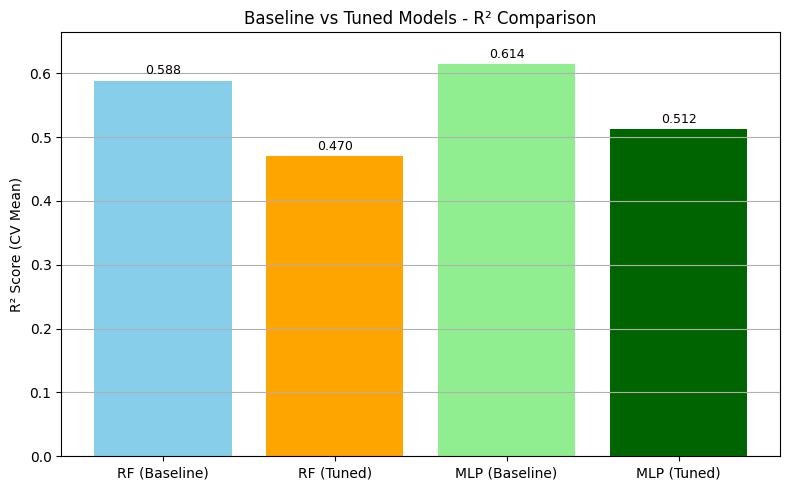

In [14]:
import matplotlib.pyplot as plt

# Prepare data
model_names = ['RF (Baseline)', 'RF (Tuned)', 'MLP (Baseline)', 'MLP (Tuned)']
scores = [rf_baseline_score, tuned_rf_score, mlp_baseline_score, tuned_mlp_score]
colors = ['skyblue', 'orange', 'lightgreen', 'darkgreen']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, scores, color=colors)

# Labels and title
plt.ylabel("R² Score (CV Mean)")
plt.title("Baseline vs Tuned Models - R² Comparison")
plt.ylim(0, max(scores) + 0.05)
plt.grid(axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


## Analysis

After performing hyperparameter tuning on both Random Forest and MLP models using GridSearchCV with 5-fold cross-validation; observed a decrease in R² scores compared to the default configurations:

Random Forest: 0.588 → 0.470

MLP Regressor: 0.614 → 0.512

This suggests that the tuned hyperparameter combinations may not generalize as well as the default settings on the given dataset.

Possible reasons include:

The dataset contains only ~927 samples, which may limit the effectiveness of complex model tuning.

The default parameters may already offer well-balanced performance, especially for Random Forest.

Some tuned configurations may have increased model variance or led to overfitting, particularly for neural networks.



In [15]:
# 重新构造一个包含 scaler 的 pipeline，作为最终 baseline MLP 模型

X = df[selected_features]
y = df['arousal']

baseline_mlp = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42))
])

baseline_mlp.fit(X, y)

# save pipeline
joblib.dump(baseline_mlp, "/content/drive/MyDrive/emotion_from_sound_AI_project/models/baseline_mlp_pipeline.pkl")
print("Baseline MLP pipeline saved.")


Baseline MLP pipeline saved.
